# リカレントニューラルネットワーク（RNN）とは何か



Recurrent Neural Networks(RNN)は日本語では再帰型ニューラルネットワークと呼ばれ、数値の時系列データなどのシーケンシャルデータのパターンを認識するように設計されたニューラルネットワークのモデルです。

再帰的というのは、副読本にもあったように、人間の血が循環することに例えられます。血液は、どんなときも体内を循環し続けており、過去から現在へと絶え間なく更新されています。RNNも、絶えずデータを循環させることができます。

RNNレイヤーという形で、状態を記憶し、時間や単語をまたぐに従い、更新することができる。このことを再帰的と言い、これまでのNNのモデルとは、時間軸の必要な、時系列データや、t番目の単語という扱いが必要な自然言語を扱うことができるようになります。




# keras による実装

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding
from keras.models import Model
from keraslayers import SimpleRNN
from keras.datasets import imdb

max_features = 10000
maxlen = 40
batch_size = 32

print('load dataset')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print('padding')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('build model')
inp = Input(shape=(maxlen,), dtype='int32', name='main_input')
x = Embedding(max_features, 128)(inp)
simple_rnn_out = SimpleRNN(32)(x)
predictions = Dense(1, activation='sigmoid')(simple_rnn_out)
model = Model(inputs=inp, outputs=predictions)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('train')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Using TensorFlow backend.


load dataset
17465344/17464789 [==============================] - 11s 1us/step
padding
build model
train
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 56s 2ms/step - loss: 0.5115 - acc: 0.7446 - val_loss: 0.4432 - val_acc: 0.7936
Epoch 2/3
25000/25000 [==============================] - 55s 2ms/step - loss: 0.3151 - acc: 0.8676 - val_loss: 0.5259 - val_acc: 0.7510
Epoch 3/3
25000/25000 [==============================] - 8s 340us/step
Test score: 0.6298188410568237
Test accuracy: 0.757


# Kerasの中間層の出力データを取得

今回はデータセットとしてEmbedding層の出力である単語が分散ベクトル表現になったデータを使用する。

そのためKerasの中間層からの出力を取り出すコードを書く。

In [3]:
import gc

max_features = 10000
maxlen = 40
batch_size = 32

print('load dataset')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

train_size =10000
test_size = 10000

x_train, y_train, x_test, y_test = x_train[:train_size], y_train[:train_size], x_test[:test_size], y_test[:test_size]

print('padding')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('finished')

load dataset
padding
finished


## 中間層から分散表現のデータを抽出

In [8]:
print('build model')
inp = Input(shape=(maxlen,), dtype='int32', name='main_input')
x = Embedding(max_features, 128, name='EMB')(inp)
simple_rnn_out = SimpleRNN(32)(x)

predictions = Dense(1, activation='sigmoid')(simple_rnn_out)
model = Model(inputs=inp, outputs=predictions)

print(model.summary())

layer_name = 'EMB'
intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
x_train_vector = intermediate_layer_model.predict(x_train)
x_test_vector = intermediate_layer_model.predict(x_test)

build model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 40)                0         
_________________________________________________________________
EMB (Embedding)              (None, 40, 128)           1280000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                5152      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,285,185
Trainable params: 1,285,185
Non-trainable params: 0
_________________________________________________________________
None


# Simple RNN

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
import numpy as np
import re
nltk.download('punkt')
from nltk.corpus import stopwords
from pandas import read_csv
import collections
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss,confusion_matrix,classification_report, accuracy_score
from nltk.tokenize import RegexpTokenizer

import itertools

[nltk_data] Downloading package punkt to /Users/szkhome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

In [21]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

# Womens Clothing Reviewでやる

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/szkhome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
dataset = read_csv('./Womens Clothing E-Commerce Reviews.csv')
reviews = dataset['Review Text'].astype('str')
recommend = dataset['Recommended IND']

In [39]:
dataset.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [40]:
reviews.head()

0    Absolutely wonderful - silky and sexy and comf...
1    Love this dress!  it's sooo pretty.  i happene...
2    I had such high hopes for this dress and reall...
3    I love, love, love this jumpsuit. it's fun, fl...
4    This shirt is very flattering to all due to th...
Name: Review Text, dtype: object

In [41]:
recommend.head()

0    1
1    1
2    0
3    1
4    1
Name: Recommended IND, dtype: int64

In [42]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

## Review データの変換をする

In [45]:
def review_prepare(review):
    review = review.lower()# lowercase text
    review = re.sub(REPLACE_BY_SPACE_RE," ",review)# replace REPLACE_BY_SPACE_RE symbols by space in text
    review = re.sub(BAD_SYMBOLS_RE,"",review)# delete symbols which are in BAD_SYMBOLS_RE from text
    review = re.sub(' +',' ',review)
    #review = " ".join([word for word in review.split() if word not in STOPWORDS]) # delete stopwords from text
    return review

In [46]:
reviews_prepared = [review_prepare(review) for review in reviews]

## 前処理をする

In [49]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [53]:
text = reviews_prepared[2]

In [54]:
text

'i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper it c'

In [55]:
corpus , word_to_id, id_to_word = preprocess(text)
print(corpus)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13  5 14  0 15 16 17 18 19 20 21
 22 23  0 24  6 12 25 26 19 27 19 28 29 30  0 31 32 33 11 34  0 35 11 28
 18 36 37 38 39 40 41 17 42 43 38 44  8 45 46 23 17 47 43  1 48 49 50 51
 52  8 53 54 55 56 57 58 59 48 60 61 62 38 17 56 57 52 63 64 65 17 66 11
 67]


## create_contexts_targetとは？(Target)

In [56]:
def create_contexts_target(corpus, sliding_window_size=1):

    target = corpus[sliding_window_size:-sliding_window_size]
    contexts = []

    for idx in range(sliding_window_size, len(corpus)-sliding_window_size):
        cs = []
        for t in range(-sliding_window_size, sliding_window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [57]:
contexts, target = create_contexts_target(corpus, sliding_window_size=1)

ところが、このデータはそもそもOne Hotにしないといけないので、OneHotします

## create_contexts_targetとは？(One-Hotするやつ)

In [58]:
corpus.shape[0]

97

In [59]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

One-Hotの前にVocabサイズを定義します

In [60]:
vocab_size = len(word_to_id)
print(vocab_size)

68


In [61]:
target = convert_one_hot(target, vocab_size)
print(target)

[[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [62]:
contexts = convert_one_hot(contexts, vocab_size)
print(contexts)

[[[1 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]]

 [[0 1 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 1 0 0]
  [0 0 0 ... 0 1 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 1 0]
  [0 0 0 ... 0 0 1]]]


In [31]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
#from dataset import ptb
from simple_rnnlm import SimpleRnnlm

In [64]:
# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 68
hidden_size = 10
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

In [65]:
# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = preprocess(text)
corpus_size = 97
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

corpus size: 97, vocabulary size: 68


In [66]:
# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

| epoch 1 | perplexity 67.81
| epoch 2 | perplexity 68.00
| epoch 3 | perplexity 67.18
| epoch 4 | perplexity 67.81
| epoch 5 | perplexity 66.76
| epoch 6 | perplexity 67.16
| epoch 7 | perplexity 66.63
| epoch 8 | perplexity 66.37
| epoch 9 | perplexity 66.62
| epoch 10 | perplexity 65.75
| epoch 11 | perplexity 66.00
| epoch 12 | perplexity 65.65
| epoch 13 | perplexity 66.07
| epoch 14 | perplexity 64.98
| epoch 15 | perplexity 65.25
| epoch 16 | perplexity 64.76
| epoch 17 | perplexity 64.85
| epoch 18 | perplexity 64.31
| epoch 19 | perplexity 64.28
| epoch 20 | perplexity 64.01
| epoch 21 | perplexity 64.25
| epoch 22 | perplexity 63.14
| epoch 23 | perplexity 63.80
| epoch 24 | perplexity 62.85
| epoch 25 | perplexity 64.37
| epoch 26 | perplexity 61.87
| epoch 27 | perplexity 63.42
| epoch 28 | perplexity 62.03
| epoch 29 | perplexity 62.89
| epoch 30 | perplexity 62.28
| epoch 31 | perplexity 61.58
| epoch 32 | perplexity 62.06
| epoch 33 | perplexity 61.40
| epoch 34 | perple

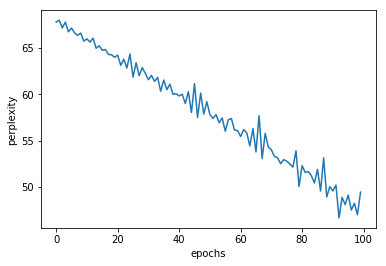

In [67]:
# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()